<a href="https://colab.research.google.com/github/lleviraz/urban_segmentation/blob/main/notebooks/DeepLab_Final_Proj_Segmentation_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation of Residential and Non Residential Built-Up areas

(Sentienl2 satellite images with ESM masks)

This notebook contains the Segmentation pipeline using fastai
It assumes that the dataset was already preprocessed and available 
in two directories:
- s2_resized - the input images
- esm_aligned - the ESM masks

It will create 3 new directories:
- s2_resized_test - test samples not used in training, nor validation
- esm_resized_test - masks of the above test images (unused)
- preds - predicted masks based on test data

By: Eli T. and Liad.L.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
!pip install fastai wwf nbdev rasterio geopandas fastbook tiffile imagecodecs pytorch-ignite -q
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf','fastbook','torch','torchvision','rasterio','pytorch-ignite'])

In [ ]:
# Python General
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
import glob
from tqdm.notebook import tqdm
import pprint as pp
from PIL import Image
import numpy as np

#Torch
from torch import nn
import torch
import torch.nn.functional as F
from torchvision.transforms import *
from torchvision.transforms.functional import InterpolationMode
from torchvision.models.resnet import resnet18,resnet34,resnet50,resnet101,wide_resnet50_2,resnext101_32x8d
from ignite.metrics import SSIM


#rasterio
import rasterio as rio
from rasterio.transform import Affine
from rasterio.plot import show_hist,show
from rasterio.warp import calculate_default_transform, reproject, Resampling

#fastai
from fastcore.xtras import Path
from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos
from fastai.data import *
from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize
from fastai.layers import Mish
from fastai.losses import BaseLoss,DiceLoss,FocalLossFlat
from fastai.optimizer import ranger,Adam
from fastai.torch_core import tensor
from fastai.vision.all import *
from fastai.vision.augment import aug_transforms
from fastai.vision.learner import unet_learner
from fastai.vision import *
from fastai.vision.core import *
from fastai.vision.data import *
from fastai.basics import *

In [ ]:
import torch
import random
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [ ]:
EXPORT_DIR='/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset'
os.chdir('/content/drive/MyDrive/2022/S1/3624_Final_Project/notebooks')
sys.path.append('/content/drive/MyDrive/2022/S1/3624_Final_Project/notebooks')

ESM_DIR = EXPORT_DIR + '/ESM'
S2_DIR = EXPORT_DIR + '/S2'

esm_aligned = os.path.join(EXPORT_DIR ,'esm_aligned/')
s2_resized = os.path.join(EXPORT_DIR,'s2_resized/')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu' #GOOD FOR DEBUGGING
print('Using device:', device)

# Validate that the generated masks and plot some samples of the transformed MASKs with original and matching image

Note: the class proprtions are saved, except for the 'no-data' at the margins (white triangle areas), which are minimized due to the alignment.

In [ ]:
from libs.preprocess import *
from libs.metrics import *
from libs.multichannel import *
from libs.metrics import _fast_hist


orig_mask,new_mask,orig_img = None,None,None
#Uncomment to run validation
# orig_mask,new_mask,orig_img = validate_dataset(s2_resized,esm_aligned,ESM_DIR)

In [ ]:
if (new_mask != None):
  print('---------------------------------')
  print(orig_mask.name,'\n',orig_mask.meta)
  print('---------------------------------')
  print(new_mask.name,'\n',new_mask.meta)
  print('---------------------------------')
  print(orig_img.name,'\n',orig_img.meta)
  print('---------------------------------') 

# Segmenation Experiments


# Save ~7% of the images (and their matching labels) for test

In [ ]:
# !ls ../dataset/s2_resized_test | wc -l
# !ls ../dataset/esm_aligned_test/ | wc -l

In [ ]:
# ! mv ../dataset/s2_resized_test/*.tif ../dataset/s2_resized
# ! mv ../dataset/esm_aligned_test/*.tif ../dataset/esm_aligned

In [ ]:
# !rm -rf ../dataset/s2_resized_test/
# !rm -rf ../dataset/esm_aligned_test/

In [ ]:
import shutil
S2_TEST_DIR = os.path.join(EXPORT_DIR,'s2_resized_test')
ESM_TEST_DIR = os.path.join(EXPORT_DIR,'esm_aligned_test')

def create_test_set():

  if(os.path.isdir(S2_TEST_DIR)):
    print('{} Directory exists,\n exiting. (To recreate, move files back to original dirs BEFORE DELETING(!!!) and rerun)'.format(S2_TEST_DIR))
    target = os.listdir(S2_TEST_DIR)
    number_files = len(target)
    print(number_files)
  else:
    print('Creating ',S2_TEST_DIR)
    print('Creating ',ESM_TEST_DIR)
    os.makedirs(S2_TEST_DIR)
    os.makedirs(ESM_TEST_DIR)
    s2_source = s2_resized
    esm_source = esm_aligned
    files = os.listdir(s2_source)
    no_of_files = 50#int(len(files) *0.07)

    for file_name in random.sample(files, no_of_files):
        shutil.move(os.path.join(s2_source, file_name), S2_TEST_DIR)
        shutil.move(get_matching_mask_path(file_name,esm_source), ESM_TEST_DIR)

create_test_set()

/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized_test Directory exists,
 exiting. (To recreate, move files back to original dirs BEFORE DELETING(!!!) and rerun)
50


In [ ]:
trn = glob.glob(os.path.join(s2_resized,'*.tif'))
trn_number_files = len(trn)
print('{} train files in {}'.format(trn_number_files,s2_resized))
tst = glob.glob(os.path.join(S2_TEST_DIR,'*.tif'))
tst_number_files = len(tst)
print('{} test files in {}'.format(tst_number_files,S2_TEST_DIR))

650 train files in /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/
50 test files in /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized_test


In [ ]:
#check a sample of the expected image and matching mask both ways
sample_mask = get_matching_mask_path(trn[0],esm_aligned)
assert sample_mask != None
sample_image = get_matching_img_path(sample_mask,s2_resized)
assert sample_image != None

# Custom Classes for Segmentation of Multi Channel Tiff Images

 - MCISegmentationDataLoaders - an extension of fastai's [SegmentationDataLoaders](https://docs.fast.ai/vision.data.html#SegmentationDataLoaders) to support multi channel Tiff images 
 - MultiChannelImage  - Enhancing the basic [TensorImage](https://docs.fast.ai/torch_core.html#TensorImage) 

Both classes are defined in `libs.multichannel.py`


In [ ]:
fnames = get_image_files(s2_resized)
lbl_names = get_image_files(esm_aligned)
fnames,lbl_names

((#650) [Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_0.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_1.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_2.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_3.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_4.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_5.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_9.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_6.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_11.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_10.tif')...],
 (#650) [Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/ESM_0.tif'),Path('/content/dr

### Classes codes decoder dictionary (0,1,2,3)->(0,1,250,255)

In [ ]:
codes = ['0_0_No_Data','1_1_Land','2_250_Non_Resi_BU','3_255_Resi_BU']
codes

['0_0_No_Data', '1_1_Land', '2_250_Non_Resi_BU', '3_255_Resi_BU']

In [ ]:
# From np.unique(mask)
mask_vals = {0:0,1:1,2:250,3:255}

In [ ]:
def get_msk(img_name,mask_dir, p2c=mask_vals,merge_bg=False):
  '''
  returns a matching mask for an image using the codes decoder dictionary (0,1,2,3)->(0,1,250,255)
  '''
  fn = get_matching_mask_path(img_name,mask_dir)
  msk = np.array(PILMask.create(fn))

  for i, val in enumerate(p2c):
    msk[msk==p2c[i]] = val
  if(merge_bg):
    msk[msk==0] = 1
  msk[0,0]=0 #save one pixel as 0 to preseve the "colors" when comparing
  return PILMask.create(msk)

In [ ]:
img_fn = fnames[1].name
msk = get_msk(img_fn,esm_aligned,mask_vals)
# msk2 = get_msk(img_fn,esm_aligned,mask_vals)#,merge_bg=True)

(array([0, 1, 2, 3], dtype=uint8), array([ 4391, 69939,    24, 15646]))

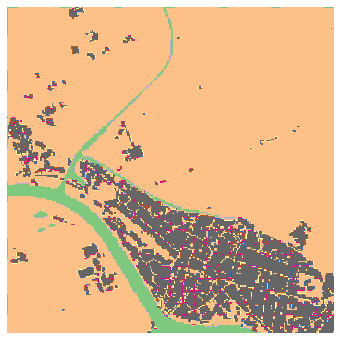

In [ ]:
cm='Accent' #'nipy_spectral_r'
f,axs = plt.subplots(1,1,figsize=(6,6))
msk.show(figsize=(5,5), alpha=1.,cmap=cm,ax=axs)
# msk2.show(figsize=(5,5), alpha=1.,cmap=cm,ax=axs[1])
np.unique(tensor(msk),return_counts=True)#,np.unique(tensor(msk2),return_counts=True)

In [ ]:
#Tensor mask with coded values (0,1,2,3)
tensor(msk)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 3, 3, 3],
        [1, 1, 1,  ..., 3, 3, 1],
        [1, 1, 1,  ..., 3, 3, 1]], dtype=torch.uint8)

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
name2id

{'0_0_No_Data': 0, '1_1_Land': 1, '2_250_Non_Resi_BU': 2, '3_255_Resi_BU': 3}

In [ ]:
# no_data_code = name2id['3_0_No_Data']
# no_data_code

# DeepLab

## Segmentation tasks
Due to PIL limitations we need custom solutions for geotiff raster masks

## Metrics: IoU (Jaccard Index) ,Dice Score , Accuracy

In [ ]:
def overall_acc(inp, targ):
  '''
  Overall pixel accuracy (not a good metric...)
  '''
  hist = prep_hist(inp,targ)
  return overall_pixel_accuracy(hist)

In [ ]:
def per_cls_acc(inp, targ):
  '''
  Per class pixel accuracy (not a bad metric...)
  '''
  hist = prep_hist(inp,targ)
  return per_class_pixel_accuracy(hist)

In [ ]:
def iou(inp, targ):
  '''
  IoU - Intersection over Union , Jaccard index
  '''
  hist = prep_hist(inp,targ)
  return jaccard_index(hist)

In [ ]:
def dice(inp, targ):
  '''
  Calculates the Dice coefficient between two images
  '''
  hist = prep_hist(inp,targ)
  return dice_coefficient(hist)

In [ ]:
def foreground_acc(inp, targ, bkg_idx=1, axis=1):
    "Computes non-background accuracy for multiclass segmentation without the background class" 
    targ = cast(targ.squeeze(1), TensorBase)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean()

# A Combined Loss function

A combined loss DiceLoss + Focal loss, that takes care of the class imbalance in the dataset https://docs.fast.ai/losses.html

Tuning the "gamma" and "alpha" hyperparams is critical.

FocalLoss: https://amaarora.github.io/2020/06/29/FocalLoss.html

Inspiration from this paper:
[Unified Focal loss: Generalising Dice and cross entropy-based losses to handle class imbalanced medical image segmentation](https://paperswithcode.com/paper/a-mixed-focal-loss-function-for-handling )

Code is at: `libs.multichannel.py`

# Hyperparams

In [ ]:
#Training images dir
TRAIN = s2_resized

### Augmentations

Required for multi channel images (and their masks) using [Albumenations](https://albumentations.ai/docs/examples/example_kaggle_salt/#Using-Albumentations-for-a-semantic-segmentation-task)

In [ ]:
#DEBUG / TEST trying to apply the dataset statistics values
# stats_mean_df = pd.read_csv('stats_mean_df.csv',index_col=0,header=0)
# stats_std_df  = pd.read_csv('stats_std_df.csv',index_col=0,header=0)

# means=list(stats_mean_df.mean().values)
# stds=list(stats_std_df.mean().values)
# s2_stats = (means,stds)

In [ ]:
#TODO move to multichannel.py
#Trying Albumenations as regular torch Augmentations support only 3 channels
import albumentations as A
width=300
height=300
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x

        # for albumentations to work correctly, the channels must be at the last dimension
        aug = self.aug(image=np.array(img.permute(1,2,0)), mask=np.array(mask))
        return TensorImage(aug['image'].transpose(2,0,1)), TensorMask(aug['mask'])

ppp=0.45
#From https://albumentations.ai/docs/examples/example_kaggle_salt/#Using-Albumentations-for-a-semantic-segmentation-task
#Half size is a popular choice of augmenation for segmentation tasks
aug_pipe = A.Compose([A.RandomSizedCrop(min_max_height=(150, 150), height=height, width=width, p=ppp),
    A.PadIfNeeded(min_height=height, min_width=width, p=1),
    A.VerticalFlip(p=ppp),
    A.RandomRotate90(p=ppp),
    A.RandomBrightnessContrast(p=ppp)])


# Create our class with this aug_pipe
aug = SegmentationAlbumentationsTransform(aug_pipe)
# b_aug = [RandomHorizontalFlip(p=ppp),RandomVerticalFlip(p=ppp)]

In [ ]:
augs_list = []
for a in aug_pipe:
  augs_list.append(a.__class__.__name__)
augs_list

['RandomSizedCrop',
 'PadIfNeeded',
 'VerticalFlip',
 'RandomRotate90',
 'RandomBrightnessContrast']

In [ ]:
####################################
### Combined Focal and Dice Loss ###
####################################
#======================================================================================
#GREAT RESULTS: |1. alpha=0.1,gamma=6
#======================================================================================
loss_fn=CombinedLoss(alpha=0.1,gamma=6)

#######################
###  DiceLoss  Only ###
#######################
#loss_fn = DiceLoss(reduction="mean")
#Very bad - no learning at all

######################
### FocalLoss Only ###
######################
#axis=1,gamma=2.0
# loss_fn=FocalLossFlat(axis=1,gamma=6)
#although getting very low losses of ~0.06 - this is sometimes missing entire classes - and giving an overall lower scores
# when gamm is default , 2.0 - this is same as CE - it totally mixes entire classes (switches the pred of class 1 with 250)

#################
### CELoss ###
#################
#pass weights of each class from the EDA
# weights = torch.tensor([1e-07,0.70,0.05,0.25]).cuda()
# loss_fn = CrossEntropyLossFlat(weight=weights, axis=1)
# loss_fn=CrossEntropyLossFlat(axis=1) #Show that this is not a good LOSS for segmentation (without weights at least)
# RESULTS: cross-entropy is segmenting too small areas and has the worst scores performance (which makes sense for imbalanced dataset)
# it totally mixes entire classes (switches the pred of class 1 with 250)

In [ ]:
#Other hyper parameters

model='deeplabv3_fastai'

#DataLoader and Learner 
batch_size=5
num_epochs=200
arch= resnet50 #resnet50 #resnet34
opt=ranger #Adam
#based on feature selection in EDA
#channels=[7,9,13] #[7,12,14]
# pretrained=True
pretrained=False #can be True only if using 3 channels
channels=None
num_chan=len(channels) if channels!=None else None

# lr=0.0 #will be automatically set by lr_find
valid_pct=0.10
# normalize_input=True
normalize_input=False
#AUGMENTATIONS
item_augms = aug

batch_augms=None #Normalize.from_stats(*s2_stats)#None


In [ ]:
TRAIN = s2_resized

dl_train = MCISegmentationDataLoaders.from_label_func_segm(chans=channels,path=TRAIN, bs=batch_size, codes=codes,
                                                   fnames=get_files(TRAIN, extensions=['.tif'], recurse=False),
                                                   label_func = lambda o: get_msk(o.name,esm_aligned, mask_vals),
                                                   item_tfms=item_augms,batch_tfms=batch_augms,valid_pct=valid_pct)

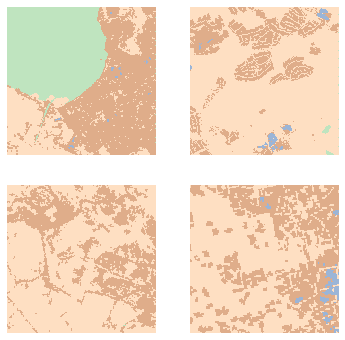

In [ ]:
cm='Accent'
dl_train.show_batch(max_n=4,figsize=(6,6),cmap=cm)

In [ ]:
print(dl_train.train.items[0], dl_train.valid.items[0])
print(len(dl_train.valid.items),len(dl_train.train.items))


/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_7_694.tif /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_7_695.tif
65 585


# Deeplab Arch Model Customization

A customization of the fastai and pytorch classes...

In [ ]:
class Conv2d(nn.Conv2d):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=True,
    ):
        super(Conv2d, self).__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
        )

    def forward(self, x):
        # return super(Conv2d, self).forward(x)
        weight = self.weight
        weight_mean = (
            weight.mean(dim=1, keepdim=True)
            .mean(dim=2, keepdim=True)
            .mean(dim=3, keepdim=True)
        )
        weight = weight - weight_mean
        std = weight.view(weight.size(0), -1).std(dim=1).view(-1, 1, 1, 1) + 1e-5
        weight = weight / std.expand_as(weight)
        return F.conv2d(
            x, weight, self.bias, self.stride, self.padding, self.dilation, self.groups
        )

In [ ]:
class ASPP(nn.Module):

    def __init__(self, C, depth, num_classes, conv=nn.Conv2d, norm=nn.BatchNorm2d, momentum=0.0003, mult=1):
        super(ASPP, self).__init__()
        self._C = C
        self._depth = depth
        self._num_classes = num_classes

        self.global_pooling = nn.AdaptiveAvgPool2d(1)
        self.relu = nn.ReLU(inplace=True)
        self.aspp1 = conv(C, depth, kernel_size=1, stride=1, bias=False)
        self.aspp2 = conv(C, depth, kernel_size=3, stride=1,
                               dilation=int(6*mult), padding=int(6*mult),
                               bias=False)
        self.aspp3 = conv(C, depth, kernel_size=3, stride=1,
                               dilation=int(12*mult), padding=int(12*mult),
                               bias=False)
        self.aspp4 = conv(C, depth, kernel_size=3, stride=1,
                               dilation=int(18*mult), padding=int(18*mult),
                               bias=False)
        self.aspp5 = conv(C, depth, kernel_size=1, stride=1, bias=False)
        self.aspp1_bn = norm(depth, momentum)
        self.aspp2_bn = norm(depth, momentum)
        self.aspp3_bn = norm(depth, momentum)
        self.aspp4_bn = norm(depth, momentum)
        self.aspp5_bn = norm(depth, momentum)
        self.conv2 = conv(depth * 5, depth, kernel_size=1, stride=1,
                               bias=False)
        self.bn2 = norm(depth, momentum)
        self.conv3 = nn.Conv2d(depth, num_classes, kernel_size=1, stride=1)

    def forward(self, x):
        x1 = self.aspp1(x)
        x1 = self.aspp1_bn(x1)
        x1 = self.relu(x1)
        x2 = self.aspp2(x)
        x2 = self.aspp2_bn(x2)
        x2 = self.relu(x2)
        x3 = self.aspp3(x)
        x3 = self.aspp3_bn(x3)
        x3 = self.relu(x3)
        x4 = self.aspp4(x)
        x4 = self.aspp4_bn(x4)
        x4 = self.relu(x4)
        x5 = self.global_pooling(x)
        x5 = self.aspp5(x5)
        x5 = self.aspp5_bn(x5)
        x5 = self.relu(x5)
        x5 = nn.Upsample((x.shape[2], x.shape[3]), mode='bilinear',
                         align_corners=True)(x5)
        x = torch.cat((x1, x2, x3, x4, x5), 1)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)

        return x

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, dilation=1, conv=None, norm=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = norm(planes)
        self.conv2 = conv(planes, planes, kernel_size=3, stride=stride,
                               dilation=dilation, padding=dilation, bias=False)
        self.bn2 = norm(planes)
        self.conv3 = conv(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = norm(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(
        self, block, layers, num_classes, num_groups=None, weight_std=False, beta=False):
        self.inplanes = 64
        self.norm = (
            lambda planes, momentum=0.05: nn.BatchNorm2d(planes, momentum=momentum)
            if num_groups is None
            else nn.GroupNorm(num_groups, planes)
        )
        self.conv = Conv2d if weight_std else nn.Conv2d

        super(ResNet, self).__init__()
        if not beta:
            self.conv1 = self.conv(
                #TODO CHANGED CHANNELS
                15, 64, kernel_size=7, stride=2, padding=3, bias=False
                # 3, 64, kernel_size=7, stride=2, padding=3, bias=False
            )
        else:
            self.conv1 = nn.Sequential(
                self.conv(3, 64, 3, stride=2, padding=1, bias=False),
                self.conv(64, 64, 3, stride=1, padding=1, bias=False),
                self.conv(64, 64, 3, stride=1, padding=1, bias=False),
            )
        self.bn1 = self.norm(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation=2)
        self.aspp = ASPP(
            512 * block.expansion, 256, num_classes, conv=self.conv, norm=self.norm
        )

        for m in self.modules():
            if isinstance(m, self.conv):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2.0 / n))
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.GroupNorm):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        downsample = None
        if stride != 1 or dilation != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                self.conv(
                    self.inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    dilation=max(1, dilation / 2),
                    bias=False,
                ),
                self.norm(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                dilation=max(1, dilation / 2),
                conv=self.conv,
                norm=self.norm,
            )
        )
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    dilation=dilation,
                    conv=self.conv,
                    norm=self.norm,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        size = (x.shape[2], x.shape[3])
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.aspp(x)
        x = nn.Upsample(size, mode="bilinear", align_corners=True)(x)
        return x

In [ ]:
def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls["resnet50"]))
    return model

# DeepLab Learner

In [ ]:
learn = None
import gc 
gc.collect()

8181

In [ ]:
# from torch.optim import AdamW

learn = Learner(
    dl_train,
    resnet50(num_classes=len(codes)),
    #callback_fns=[ShowGraph],
    metrics=[overall_acc,per_cls_acc,iou,dice,DiceMulti,foreground_acc],
    loss_func=loss_fn,
    # act_cls = Mish,
    opt_func=opt
).to_fp16()

In [ ]:
learn.summary()

ResNet (Input shape: 5 x 15 x 300 x 300)
Layer (type)         Output Shape         Param #    Trainable 
                     5 x 64 x 150 x 150  
Conv2d                                    47040      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     5 x 64 x 75 x 75    
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     5 x 256 x 75 x 75   
Conv2d                                    16384      True      
BatchNorm2d                            

In [ ]:
from datetime import datetime
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

date and time = 04/04/2022 09:40:31


In [ ]:
final_states_dict_file = Path('../models/deeplab_final_model.pth')
INFERECE_MODE=final_states_dict_file.is_file()

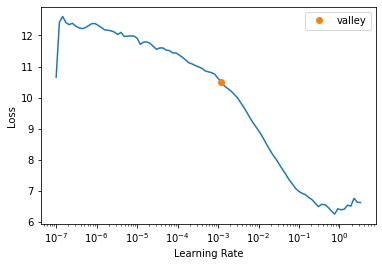

In [ ]:
if(INFERECE_MODE):
  print('Inference mode: skipping training, loading model states dict...')
  learn.load_state_dict(torch.load(final_states_dict_file))
else:
  l = learn.lr_find()

In [ ]:
if(not INFERECE_MODE):
  min_grad_lr = l.valley
  print(min_grad_lr)

0.0012022644514217973


In [ ]:
if(INFERECE_MODE):
  print('Inference mode, skip training')
else:
  learn.fit_flat_cos(num_epochs,lr=min_grad_lr,
                    #  cbs=[SaveModelCallback(monitor='dice_multi',comp=np.greater),
                         cbs=[SaveModelCallback(),
                          EarlyStoppingCallback(monitor='valid_loss', patience=15),
                          ReduceLROnPlateau( patience=3)])
  


Better model found at epoch 0 with valid_loss value: 15.335061073303223.
Better model found at epoch 1 with valid_loss value: 12.171162605285645.
Better model found at epoch 2 with valid_loss value: 11.982810974121094.
Better model found at epoch 3 with valid_loss value: 10.700994491577148.
Better model found at epoch 4 with valid_loss value: 4.187732696533203.
Better model found at epoch 5 with valid_loss value: 2.0552234649658203.
Better model found at epoch 6 with valid_loss value: 1.9732849597930908.
Better model found at epoch 7 with valid_loss value: 1.6474723815917969.
Better model found at epoch 10 with valid_loss value: 1.6213500499725342.
Epoch 13: reducing lr to 0.00012022644514217973
Better model found at epoch 14 with valid_loss value: 0.7969813942909241.
Better model found at epoch 15 with valid_loss value: 0.5775197148323059.
Better model found at epoch 16 with valid_loss value: 0.49355220794677734.
Epoch 19: reducing lr to 0.00012022644514217973
Better model found at ep

In [ ]:
#TODO this is not the best values just the last ones...

log = learn.recorder.log
log

(#10) [45,0.12071334570646286,0.13833844661712646,0.6669101715087891,0.5630176067352295,0.3616858720779419,0.4907653331756592,0.5548375387411119,0.36967578530311584,'00:25']

In [ ]:
learn.recorder.log

(#10) [45,0.12071334570646286,0.13833844661712646,0.6669101715087891,0.5630176067352295,0.3616858720779419,0.4907653331756592,0.5548375387411119,0.36967578530311584,'00:25']

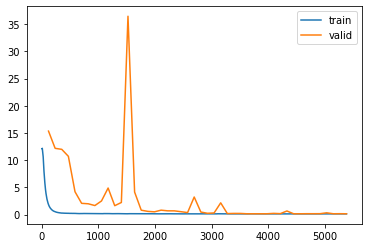

In [ ]:
if(INFERECE_MODE):
  print('Inference mode')
else:
  learn.recorder.plot_loss()

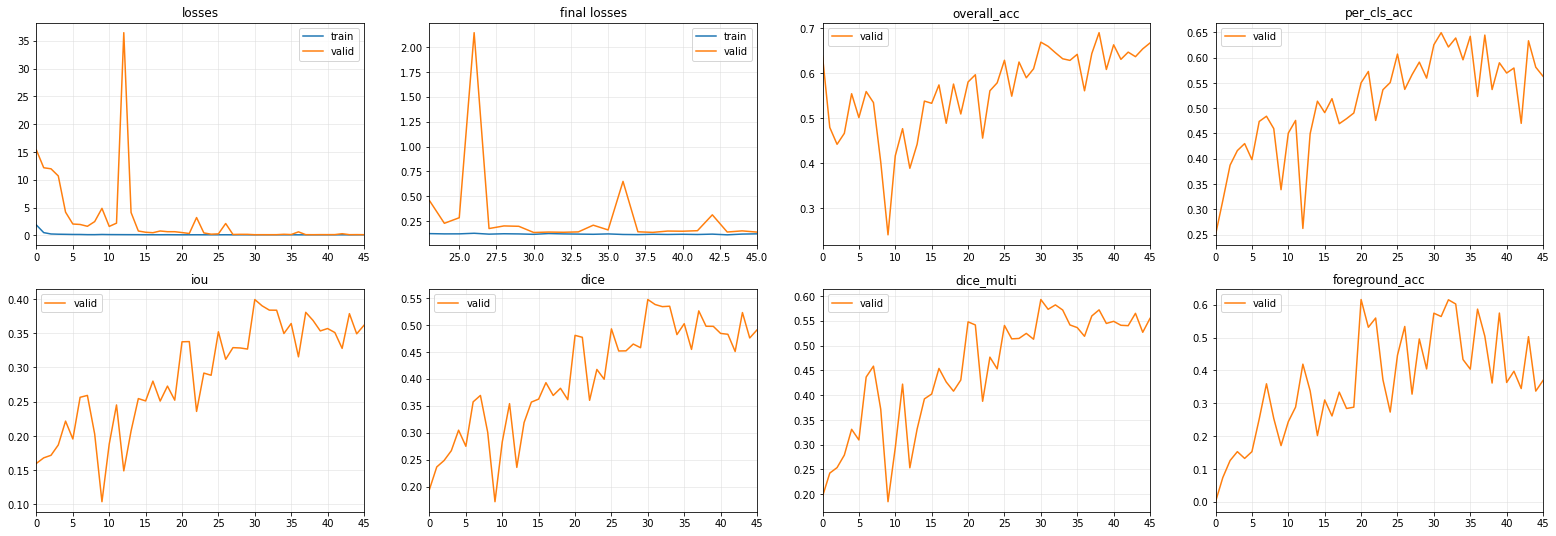

In [ ]:
if(INFERECE_MODE):
  print('Inference mode')
else:
  learn.recorder.plot_metrics()

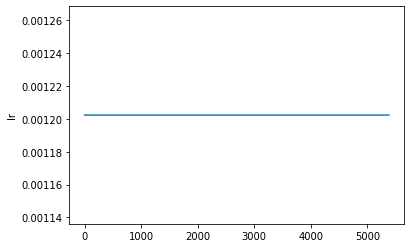

In [ ]:
#learning rate scheduleing plot
if(INFERECE_MODE):
  print('Inference mode')
else:
  learn.recorder.plot_sched()

## Store results of experiments and save to a log


In [ ]:
if(INFERECE_MODE):
  print('Inference mode')
else:
  cols=['datetime','model','num_epochs','loss_fn','batch_size',
      'arch','optim','channels','pretrained','lr','valid_pct',
      'trn_loss','val_loss','acc','per_cls_acc','IoU','Dice','DiceMulti', 'foreground_acc','item_augs','batch_augs','epoch_time']
  results=pd.DataFrame(columns=cols)
  if loss_fn.__class__.__name__.startswith('CombinedLoss'):
    loss_display = loss_fn.display()
  else:
    loss_display=(loss_fn.__class__.__name__)
  new_expriment_log=[dt_string,model,log[0],loss_display,batch_size,
      arch.__name__,opt.__name__,channels,pretrained,min_grad_lr,valid_pct,
      log[1],log[2],log[3],log[4],log[5],log[6],log[7],log[8],augs_list,batch_augms,log[-1]]

  results.loc[len(results)] = new_expriment_log
  results

In [ ]:
if(INFERECE_MODE):
  print('Inference mode')
else:
  results.to_csv('logs/deeplab_results_log.csv', mode='a', index=False, header=False)


## Inference - Display some results

In [ ]:
# Learner.dls = dl_train

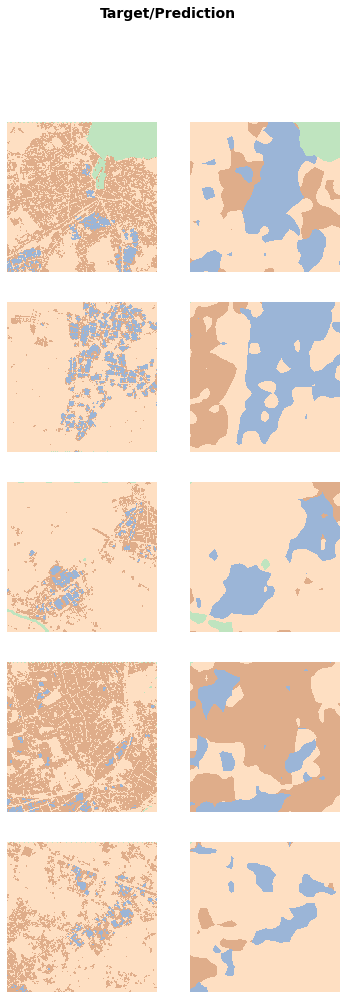

In [ ]:
#TODO see if we can plot the image behind the masks...
cm='Accent' #'nipy_spectral_r'
learn.show_results(max_n=6, figsize=(6,16),cmap=cm)

### Compare class proprtions , similiarity of original and generated masks

First "predict" a mask for all the **training** data

In [ ]:
fnames = get_image_files(s2_resized)

dl = learn.dls.test_dl(fnames)
preds = learn.get_preds(dl=dl)
preds[0].shape


torch.Size([650, 4, 300, 300])

In [ ]:
df_new_mask_class_counts = pd.DataFrame(columns=['0','1','2','3'])
for pred_mask in preds[0]:
  pred_arx = pred_mask.argmax(dim=0)
  add_cls_counts(df_new_mask_class_counts,pred_arx,classes_dic={'0':0,'1':0,'2':0,'3':0})

In [ ]:
om=pd.read_csv('orig_masks_bu_area.csv',index_col=0,header=None)
# om=pd.read_csv('orig_masks_bu_area_w_nodata.csv',index_col=0,header=None)


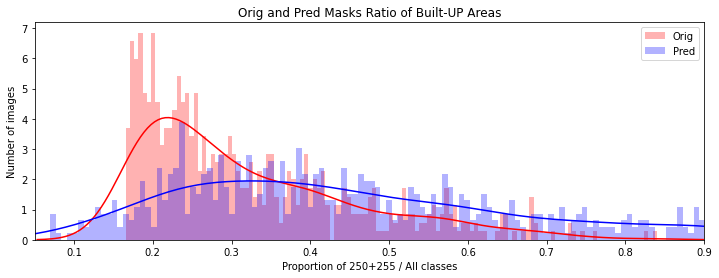

In [ ]:
# nm=get_bu_area_ratio(df_new_mask_class_counts,with_no_data=True)
nm=get_bu_area_ratio(df_new_mask_class_counts)

f,ax1 = plt.subplots(1,1,figsize=(12,4))
plot_hist(om,None,ax1,'Red',lbl='Orig')
plot_hist(nm,'Orig and Pred Masks Ratio of Built-UP Areas',ax1,'Blue',lbl='Pred')
plt.show()

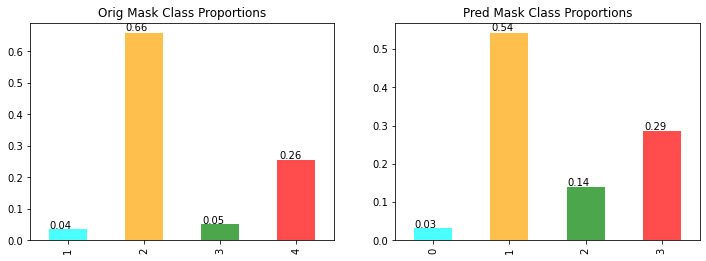

In [ ]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

df_orig_mask_class_counts = pd.read_csv('df_orig_mask_class_counts.csv',index_col=0,header=None)

plot_bar(df_orig_mask_class_counts,'Orig Mask Class Proportions',ax1)
annotate(ax1)

plot_bar(df_new_mask_class_counts,'Pred Mask Class Proportions',ax2)
annotate(ax2)
plt.show()

### Inference on unseen images

+ Saving predictions to a folder

In [ ]:
test_fnames = get_image_files(S2_TEST_DIR)

dl = learn.dls.test_dl(test_fnames)
preds = learn.get_preds(dl=dl)
preds[0].shape

torch.Size([50, 4, 300, 300])

In [ ]:
PREDS_DIR= 'deeplab_preds'
# !mkdir deeplab_preds

In [ ]:
!rm -f preds/*.tif

In [ ]:
# !pip install pytorch-ignite -q

  0%|          | 0/50 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

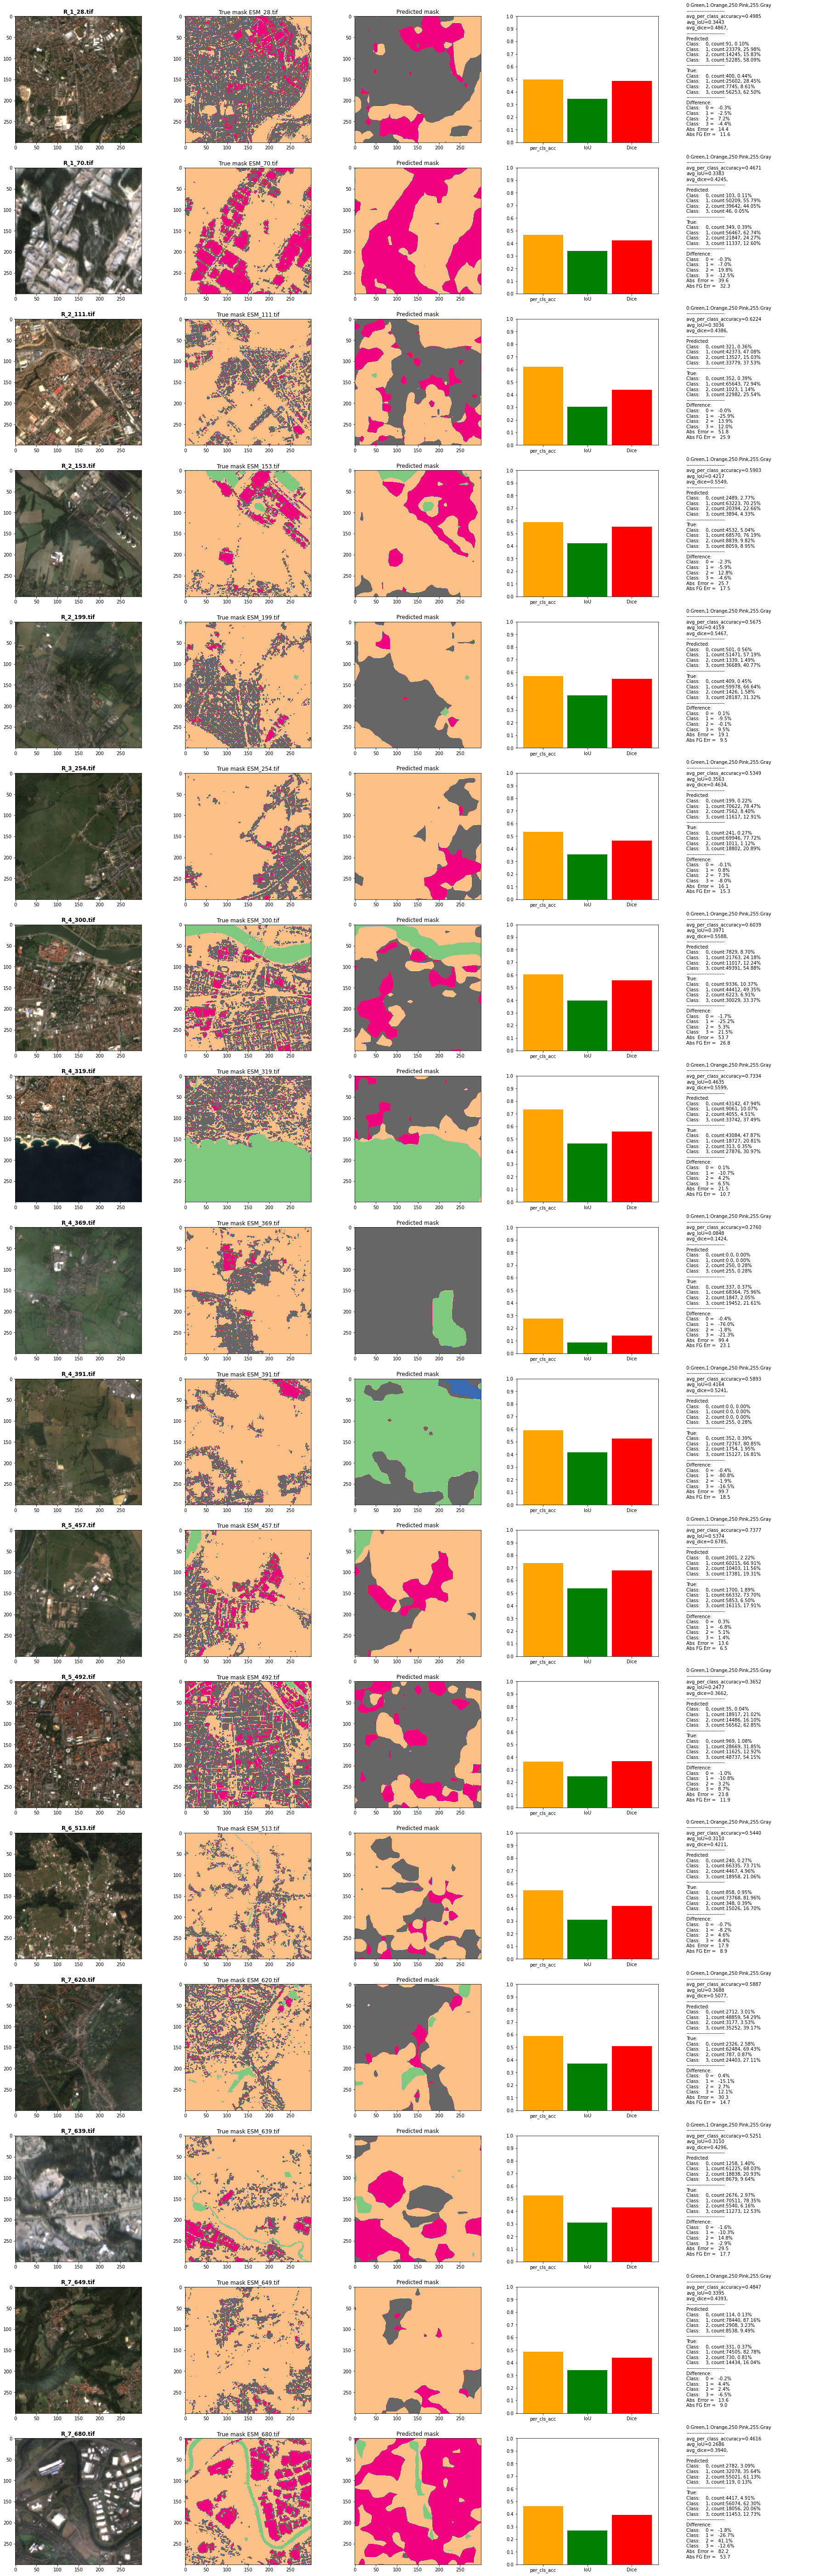

In [ ]:
cm='Accent'
show_every=3
nrows=int(len(test_fnames)/show_every)+1
f,axes = plt.subplots(nrows,5,figsize=(32,nrows*6))
j=0
with rio.Env():
  with rio.open(get_matching_mask_path(test_fnames[0].name,ESM_TEST_DIR),'r') as src:
    profile = src.profile

    for i in tqdm(range(len(test_fnames))):
      pred_1 = preds[0][i]
      pred_arx = pred_1.argmax(dim=0)

      # msk = get_msk(test_fnames[i].name,ESM_TEST_DIR,mask_vals)
      msk = get_msk(test_fnames[i].name,ESM_TEST_DIR,mask_vals)#,merge_bg=True)

      if pred_arx.shape[0]!=1:
        pred=pred_arx.unsqueeze_(0)
      true=transforms.ToTensor()(msk)
      if true.shape[0]!=1:
        true.unsqueeze_(0)
      true = true.cpu()
      pred = pred.cpu()
      pred_arx = pred_arx.cpu()

      if (i%show_every==0):
        n_clss=len(np.unique(true))
        overall_acc, avg_per_class_acc, avg_jacc, avg_dice = eval_metrics(true,pred,n_clss)
        a_s = pred_1.argmax(dim=0).unsqueeze(0).to(torch.float)
        b_s = transforms.ToTensor()(msk).unsqueeze_(0).to(torch.float)
        
        # m_ssim = SSIM(data_range=1.0); m_ssim.reset(); m_ssim.update((a_s.unsqueeze(0),b_s.unsqueeze(0))); m_ssim.compute()
        # ssim = m_ssim.compute()

        stats = calc_pred_stats(pred_arx,str(i)+' pred',mask_vals)
        orig_stats = calc_pred_stats(true,str(i)+' true',mask_vals)

        stats_diff,abs_err,abs_fg_err = get_stats_diff(stats,orig_stats)

        with rio.open(os.path.join(S2_TEST_DIR,test_fnames[i].name)) as matching_image:
          show(normalize(matching_image.read([3,2,1])),ax=axes[j,0],title=test_fnames[i].name)
        
        show(msk,ax=axes[j,1],cmap=cm)
        msk_name = get_matching_mask_path(test_fnames[i].name, ESM_TEST_DIR).split(os.path.sep)[-1]
        axes[j,1].set_title('True mask ' + msk_name)

        show(pred_arx.squeeze(0),ax=axes[j,2],cmap=cm)
        axes[j,2].set_title('Predicted mask')

        axes[j,4].axis('off')
        axes[j,4].text(0.0, 0.05, '0:Green,1:Orange,250:Pink,255:Gray \
                          \n-----------------------\navg_per_class_accuracy={:.4f} \
                          \navg_IoU={:.4f}\navg_dice={:.4f}, \
                          \n-----------------------\nPredicted:\n{}\n{}\n{}\n{} \
                          \n-----------------------\nTrue:\n{}\n{}\n{}\n{} \
                          \n-----------------------\nDifference:\n{}\n{}\n{}\n{}\n{}\n{}'.format(
                          avg_per_class_acc, avg_jacc, avg_dice,
                          *stats,*orig_stats,*stats_diff,abs_err,abs_fg_err))

        width = 0.9
        scores = ['per_cls_acc','IoU','Dice']
        x = np.arange(len(scores))
        values = [avg_per_class_acc,avg_jacc,avg_dice]
        axes[j,3].bar(x, values , width ,color=[ 'orange', 'green', 'red'])
        axes[j,3].set_xticks(x)
        axes[j,3].set_yticks(np.arange(0.0,1.1,0.1))
        axes[j,3].set_xticklabels(scores,rotation=0)
        j+=1

        #save images to target dir
        with rio.open(os.path.join(PREDS_DIR,test_fnames[i].name), 'w', **profile) as dst1:
            dst1.write(true[0].numpy().astype(rio.uint8), 1)
        with rio.open(os.path.join(PREDS_DIR,'pred_'+test_fnames[i].name), 'w', **profile) as dst2:
            dst2.write(pred_arx[0].numpy().astype(rio.uint8), 1)
plt.show()  

We can see that when the color bars are higer than Dice~0.6 the quality of the preciction is not bad
The Absolute error is the sum of the error precentage for all classes
The Absolute Foreground error is the sum of the error precentage for 250,255
We can see for some images (such R_7_685.tif or R_1_61.tif), where the "no data" was covering some real 250 and 255 - the model was able to predict them quite well...

In [ ]:
#Save final model (~700MB)
# learn.save('last_model')


References:

Some code snippets and inspiration:

https://gist.github.com/jaeeolma/0846e03c0c3b613212f8ca5824ae47e0

https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/07_Binary_Segmentation.ipynb

[Semantic Segmentation for Edge Detection](file:///C:/Users/liadl/Desktop/remotesensing-14-00613-v2.pdf)

Focal Loss paper : https://arxiv.org/pdf/1708.02002.pdf